<img src=https://i.imgur.com/WKQ0nH2.jpg height=350>

# Setup and Context


### Introduction

Welcome to Boston Massachusetts in the 1970s! Imagine you're working for a real estate development company. Your company wants to value any residential project before they start. You are tasked with building a model that can provide a price estimate based on a home's characteristics like:
* The number of rooms
* The distance to employment centres
* How rich or poor the area is
* How many students there are per teacher in local schools etc

<img src=https://i.imgur.com/WfUSSP7.png height=350>

To accomplish your task you will:

1. Analyse and explore the Boston house price data
2. Split your data for training and testing
3. Run a Multivariable Regression
4. Evaluate how your model's coefficients and residuals
5. Use data transformation to improve your model performance
6. Use your model to estimate a property price

In [1]:
# %pip install --upgrade plotly

###  Import Statements


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

### Notebook Presentation

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

# Load the Data

The first column in the .csv file just has the row numbers, so it will be used as the index. 

In [4]:
data = pd.read_csv('boston.csv', index_col=0)

### Understand the Boston House Price Dataset

---------------------------

**Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. The Median Value (attribute 14) is the target.

    :Attribute Information (in order):
        1. CRIM     per capita crime rate by town
        2. ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        3. INDUS    proportion of non-retail business acres per town
        4. CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        5. NOX      nitric oxides concentration (parts per 10 million)
        6. RM       average number of rooms per dwelling
        7. AGE      proportion of owner-occupied units built prior to 1940
        8. DIS      weighted distances to five Boston employment centres
        9. RAD      index of accessibility to radial highways
        10. TAX      full-value property-tax rate per $10,000
        11. PTRATIO  pupil-teacher ratio by town
        12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        13. LSTAT    % lower status of the population
        14. PRICE     Median value of owner-occupied homes in $1000's
        
    :Missing Attribute Values: None

    :Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of [UCI ML housing dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/). This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University. You can find the [original research paper here](https://deepblue.lib.umich.edu/bitstream/handle/2027.42/22636/0000186.pdf?sequence=1&isAllowed=y). 


# Preliminary Data Exploration 🔎

**Challenge**

* What is the shape of `data`? 
* How many rows and columns does it have?
* What are the column names?
* Are there any NaN values or duplicates?

In [5]:
data.shape

(506, 14)

In [6]:
data.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'PRICE'],
      dtype='object')

## Data Cleaning - Check for Missing Values and Duplicates

In [7]:
# data.isna().sum()

In [8]:
# data.duplicated().sum()

In [9]:
# data.drop_duplicates()

## Descriptive Statistics

**Challenge**

* How many students are there per teacher on average?
* What is the average price of a home in the dataset?
* What is the `CHAS` feature? 
* What are the minimum and the maximum value of the `CHAS` and why?
* What is the maximum and the minimum number of rooms per dwelling in the dataset?

In [10]:
print(f'So there are around {round(data.PTRATIO.mean(), 2)} students per a single teacher!')

So there are around 18.46 students per a single teacher!


In [11]:
print(f'The average price of a house ${round(data.PRICE.mean(), 3)*1000} !!!')

The average price of a house $22533.0 !!!


In [12]:
# Charles River dummy variable = 1 if tract bounds river; 0 otherwise
data.CHAS.nunique()

2

In [13]:
print(f'The maximum number of rooms {data.RM.max()} and minimum are {data.RM.min()}!!!')

The maximum number of rooms 8.78 and minimum are 3.561!!!


## Visualise the Features

**Challenge**: Having looked at some descriptive statistics, visualise the data for your model. Use [Seaborn's `.displot()`](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn.displot) to create a bar chart and superimpose the Kernel Density Estimate (KDE) for the following variables: 
* PRICE: The home price in thousands.
* RM: the average number of rooms per owner unit.
* DIS: the weighted distance to the 5 Boston employment centres i.e., the estimated length of the commute.
* RAD: the index of accessibility to highways. 

Try setting the `aspect` parameter to `2` for a better picture. 

What do you notice in the distributions of the data? 

#### House Prices 💰

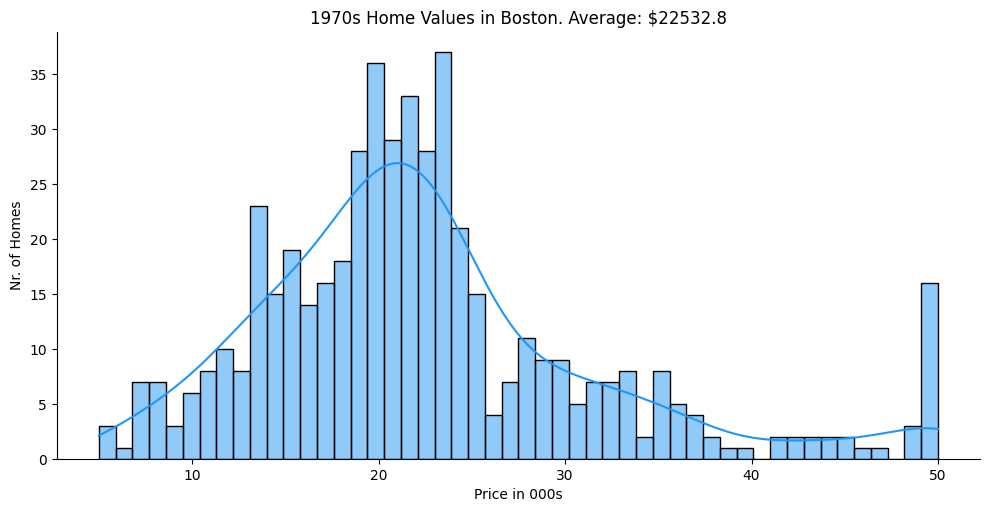

In [14]:
sns.displot(data['PRICE'], 
            bins=50, 
            aspect=2,
            kde=True, 
            color='#2196f3')

plt.title(f'1970s Home Values in Boston. Average: ${(1000*data.PRICE.mean()):.6}')
plt.xlabel('Price in 000s')
plt.ylabel('Nr. of Homes')

plt.show()

#### Distance to Employment - Length of Commute 🚗

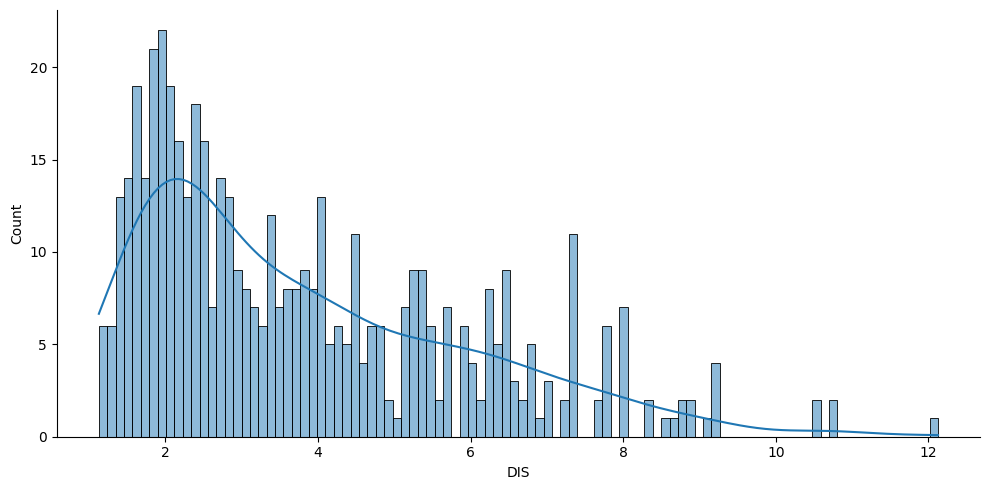

In [15]:
sns.displot(data, x='DIS', kde=True, aspect=2, bins = 100)
plt.show()

#### Number of Rooms

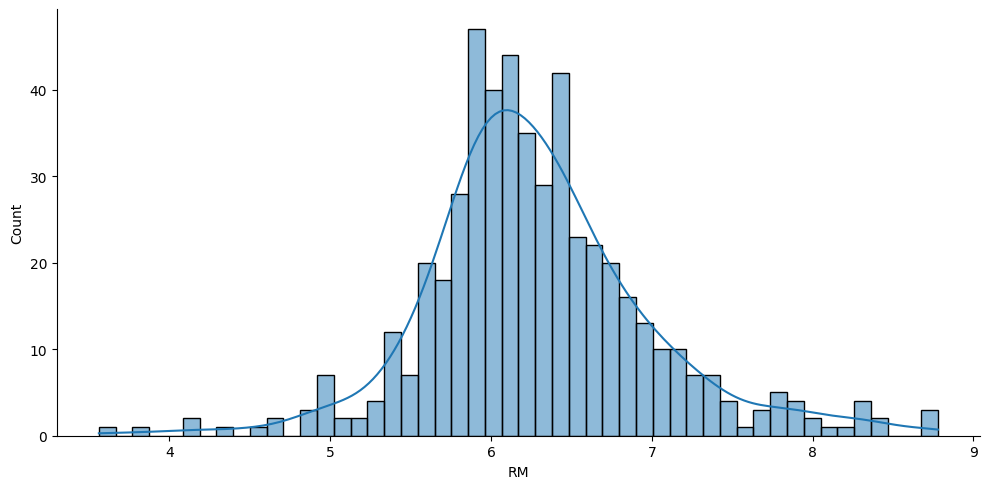

In [16]:
sns.displot(data, x='RM', kde=True, aspect=2, bins=50)
plt.show()

#### Access to Highways 🛣

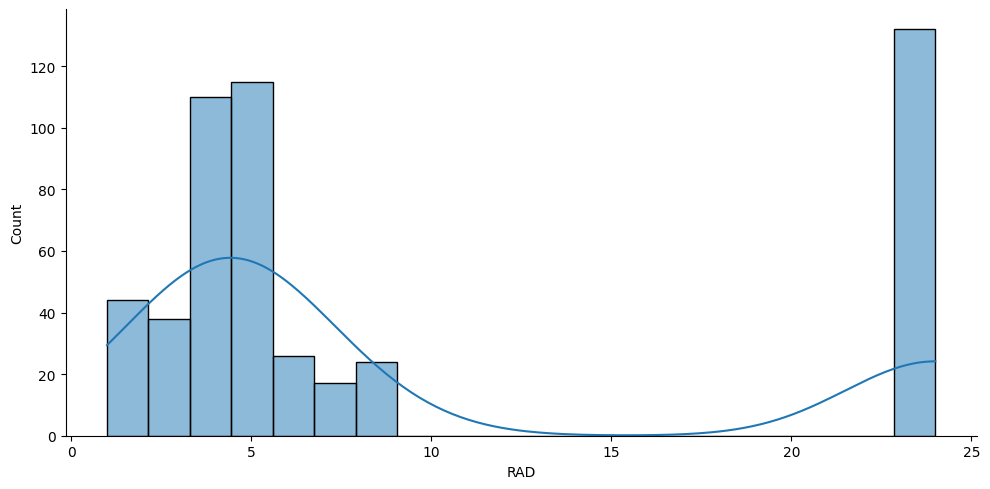

In [17]:
sns.displot(data, x='RAD', kde=True, aspect=2, bins=20)
plt.show()

#### Next to the River? ⛵️

**Challenge**

Create a bar chart with plotly for CHAS to show many more homes are away from the river versus next to it. The bar chart should look something like this:

<img src=https://i.imgur.com/AHwoQ6l.png height=350>

You can make your life easier by providing a list of values for the x-axis (e.g., `x=['No', 'Yes']`)

In [18]:
plot = px.bar(data, x=['No', 'Yes'], y=[data.shape[0]-data.CHAS.sum(), data.CHAS.sum()], color=['No', 'Yes'])
plot.update_layout(title='Next to Charles River', xaxis_title='Property located next to the river?', yaxis_title='Number of homes', )
plot.show()

<img src=https://i.imgur.com/b5UaBal.jpg height=350>

# Understand the Relationships in the Data

### Run a Pair Plot

**Challenge**

There might be some relationships in the data that we should know about. Before you run the code, make some predictions:

* What would you expect the relationship to be between pollution (NOX) and the distance to employment (DIS)? 
* What kind of relationship do you expect between the number of rooms (RM) and the home value (PRICE)?
* What about the amount of poverty in an area (LSTAT) and home prices? 

Run a [Seaborn `.pairplot()`](https://seaborn.pydata.org/generated/seaborn.pairplot.html?highlight=pairplot#seaborn.pairplot) to visualise all the relationships at the same time. Note, this is a big task and can take 1-2 minutes! After it's finished check your intuition regarding the questions above on the `pairplot`. 

In [19]:
# NOX and DIS
# sns.pairplot(data)
# plt.show()

In [20]:
sns.pairplot(data, vars=['RM', 'PRICE'])
# plt.show()

In [21]:
sns.pairplot(data, vars=['PRICE', 'LSTAT'])
# plt.show()

**Challenge**

Use [Seaborn's `.jointplot()`](https://seaborn.pydata.org/generated/seaborn.jointplot.html) to look at some of the relationships in more detail. Create a jointplot for:

* DIS and NOX
* INDUS vs NOX
* LSTAT vs RM
* LSTAT vs PRICE
* RM vs PRICE

Try adding some opacity or `alpha` to the scatter plots using keyword arguments under `joint_kws`.

#### Distance from Employment vs. Pollution

**Challenge**: 

Compare DIS (Distance from employment) with NOX (Nitric Oxide Pollution) using Seaborn's `.jointplot()`. Does pollution go up or down as the distance increases? 

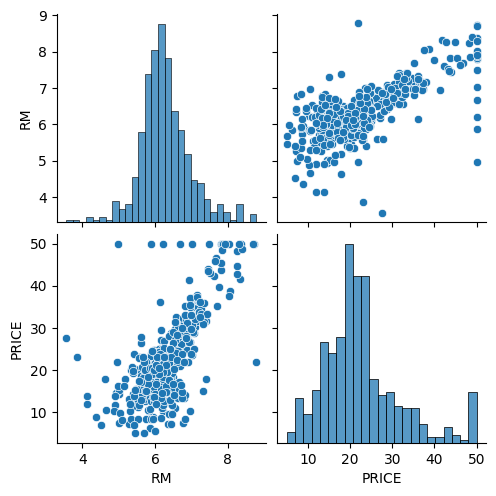

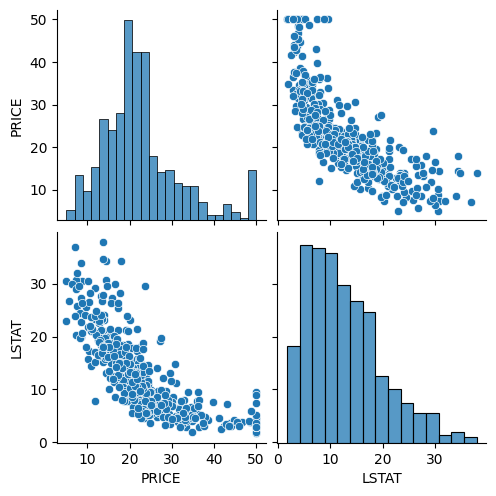

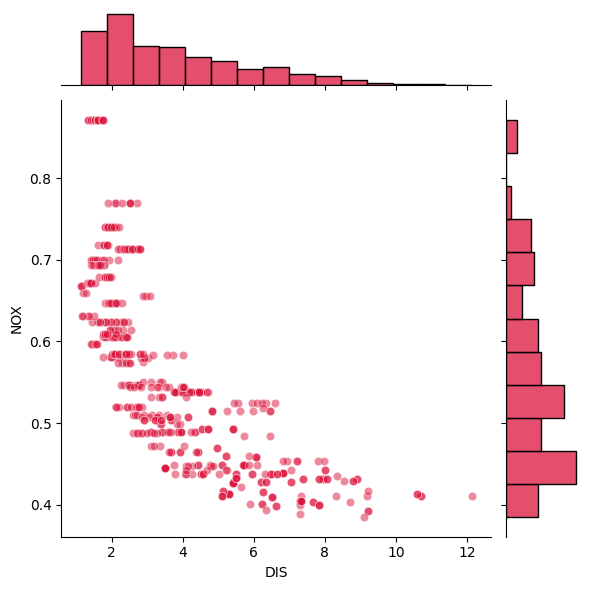

In [22]:
sns.jointplot(data=data, x='DIS', y='NOX', joint_kws={'alpha':0.5}, color='crimson')
plt.show()

#### Proportion of Non-Retail Industry 🏭🏭🏭 versus Pollution 

**Challenge**: 

Compare INDUS (the proportion of non-retail industry i.e., factories) with NOX (Nitric Oxide Pollution) using Seaborn's `.jointplot()`. Does pollution go up or down as there is a higher proportion of industry?

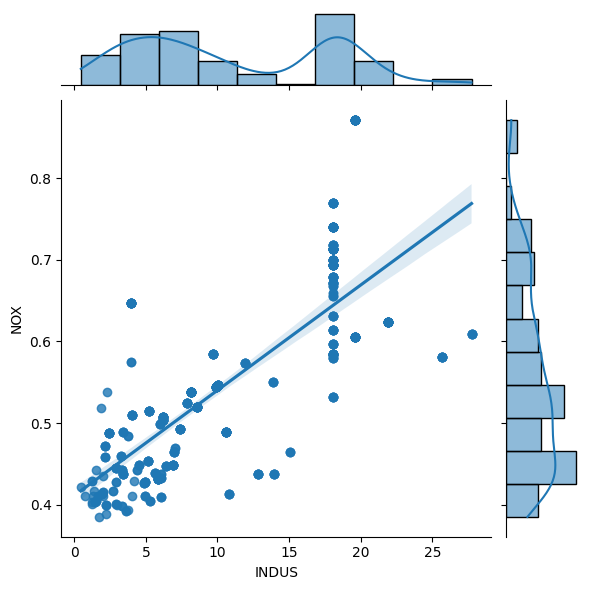

In [23]:
sns.jointplot(data=data, x='INDUS', y='NOX', kind='reg')
plt.show()

#### % of Lower Income Population vs Average Number of Rooms

**Challenge** 

Compare LSTAT (proportion of lower-income population) with RM (number of rooms) using Seaborn's `.jointplot()`. How does the number of rooms per dwelling vary with the poverty of area? Do homes have more or fewer rooms when LSTAT is low?

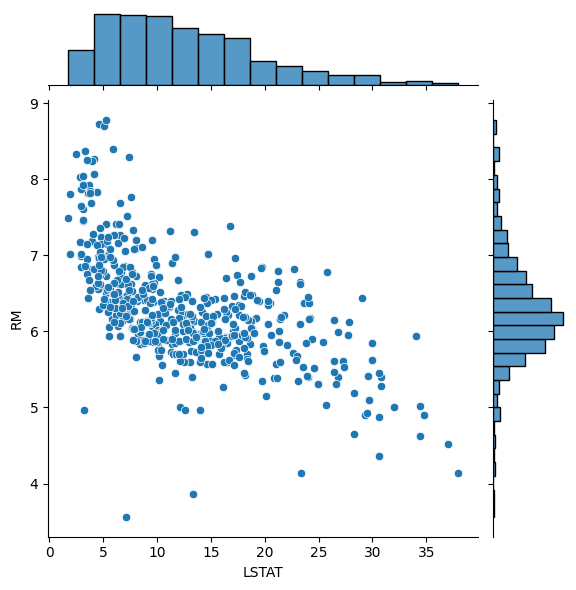

In [24]:
sns.jointplot(data=data, x='LSTAT', y='RM')
plt.show()

#### % of Lower Income Population versus Home Price

**Challenge**

Compare LSTAT with PRICE using Seaborn's `.jointplot()`. How does the proportion of the lower-income population in an area affect home prices?

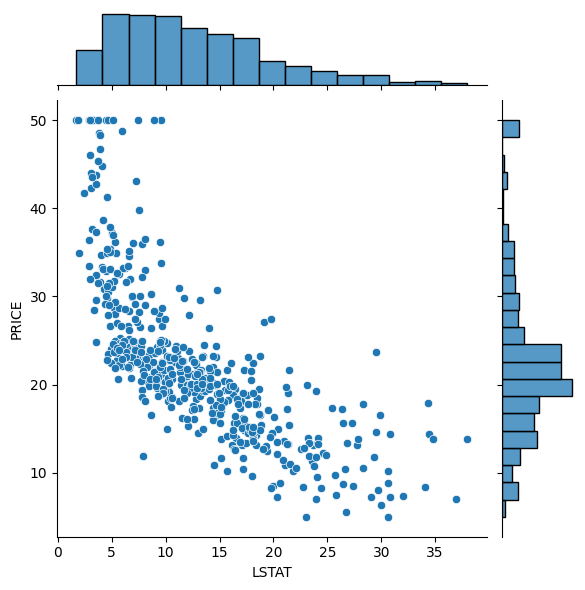

In [25]:
sns.jointplot(data=data, x='LSTAT', y='PRICE')
plt.show()

#### Number of Rooms versus Home Value

**Challenge** 

Compare RM (number of rooms) with PRICE using Seaborn's `.jointplot()`. You can probably guess how the number of rooms affects home prices. 😊 

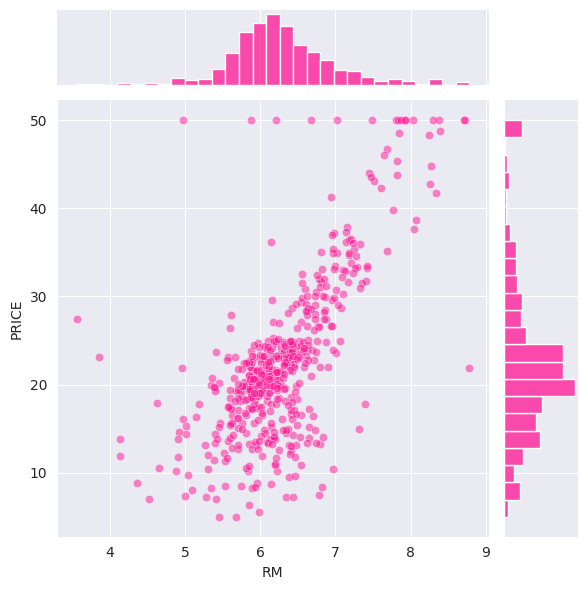

In [26]:
with sns.axes_style('darkgrid'):
    sns.jointplot(data=data, x='RM', y='PRICE', color='deeppink', joint_kws={'alpha':0.5})
plt.show()

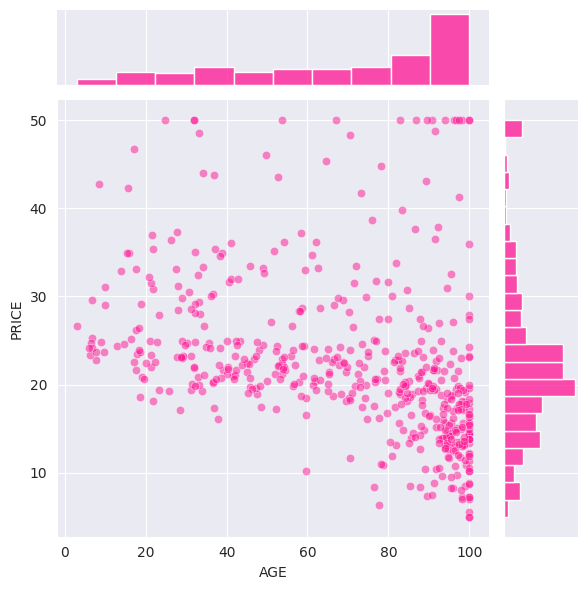

In [27]:
with sns.axes_style('darkgrid'):
    sns.jointplot(data=data, x='AGE', y='PRICE', color='deeppink', joint_kws={'alpha':0.5},)
plt.show()

# Split Training & Test Dataset

We *can't* use all 506 entries in our dataset to train our model. The reason is that we want to evaluate our model on data that it hasn't seen yet (i.e., out-of-sample data). That way we can get a better idea of its performance in the real world. 

**Challenge**

* Import the [`train_test_split()` function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from sklearn
* Create 4 subsets: X_train, X_test, y_train, y_test
* Split the training and testing data roughly 80/20. 
* To get the same random split every time you run your notebook use `random_state=10`. This helps us get the same results every time and avoid confusion while we're learning. 


Hint: Remember, your **target** is your home PRICE, and your **features** are all the other columns you'll use to predict the price. 


In [28]:
from sklearn.model_selection import train_test_split

In [29]:
features = data.drop('PRICE', axis=1)
target = data.PRICE

In [30]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=10)
X_test

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
305,0.05,33.00,2.18,0.00,0.47,6.62,58.10,3.37,7.00,222.00,18.40,393.36,8.93
193,0.02,60.00,2.93,0.00,0.40,6.80,9.90,6.22,1.00,265.00,15.60,393.37,5.03
65,0.04,80.00,3.37,0.00,0.40,6.29,17.80,6.61,4.00,337.00,16.10,396.90,4.67
349,0.03,40.00,1.25,0.00,0.43,6.94,34.50,8.79,1.00,335.00,19.70,389.85,5.89
151,1.50,0.00,19.58,0.00,0.87,5.40,100.00,1.59,5.00,403.00,14.70,341.60,13.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,0.14,0.00,10.59,1.00,0.49,6.06,59.10,4.24,4.00,277.00,18.60,381.32,14.66
174,0.08,0.00,4.05,0.00,0.51,5.86,68.70,2.70,5.00,296.00,16.60,393.23,9.64
108,0.13,0.00,8.56,0.00,0.52,6.47,97.10,2.43,5.00,384.00,20.90,395.24,12.27
242,0.10,30.00,4.93,0.00,0.43,6.36,52.90,7.04,6.00,300.00,16.60,372.75,11.22


# Multivariable Regression

In a previous lesson, we had a linear model with only a single feature (our movie budgets). This time we have a total of 13 features. Therefore, our Linear Regression model will have the following form:

$$ PR \hat ICE = \theta _0 + \theta _1 RM + \theta _2 NOX + \theta _3 DIS + \theta _4 CHAS ... + \theta _{13} LSTAT$$

### Run Your First Regression

**Challenge**

Use sklearn to run the regression on the training dataset. How high is the r-squared for the regression on the training data?

In [31]:
from sklearn.linear_model import LinearRegression

In [32]:
linear_reg = LinearRegression()

In [33]:
linear_reg.fit(X_train, y_train)

LinearRegression()

In [34]:
linear_reg.coef_

array([-1.28180656e-01,  6.31981786e-02, -7.57627602e-03,  1.97451452e+00,
       -1.62719890e+01,  3.10845625e+00,  1.62922153e-02, -1.48301360e+00,
        3.03988206e-01, -1.20820710e-02, -8.20305699e-01,  1.14189890e-02,
       -5.81626431e-01])

In [35]:
print(linear_reg.intercept_)
linear_reg.score(X_train,y_train)

36.5330513828241


0.750121534530608

In [36]:
reg_coeffs = pd.DataFrame(data=linear_reg.coef_, index=X_train.columns, columns=['Coefficient'])
reg_coeffs

,Coefficient
CRIM,-0.13
ZN,0.06
INDUS,-0.01
CHAS,1.97
NOX,-16.27
RM,3.11
AGE,0.02
DIS,-1.48
RAD,0.30
TAX,-0.01


In [37]:
X_test
# RM has a positive coefficient

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
305,0.05,33.00,2.18,0.00,0.47,6.62,58.10,3.37,7.00,222.00,18.40,393.36,8.93
193,0.02,60.00,2.93,0.00,0.40,6.80,9.90,6.22,1.00,265.00,15.60,393.37,5.03
65,0.04,80.00,3.37,0.00,0.40,6.29,17.80,6.61,4.00,337.00,16.10,396.90,4.67
349,0.03,40.00,1.25,0.00,0.43,6.94,34.50,8.79,1.00,335.00,19.70,389.85,5.89
151,1.50,0.00,19.58,0.00,0.87,5.40,100.00,1.59,5.00,403.00,14.70,341.60,13.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,0.14,0.00,10.59,1.00,0.49,6.06,59.10,4.24,4.00,277.00,18.60,381.32,14.66
174,0.08,0.00,4.05,0.00,0.51,5.86,68.70,2.70,5.00,296.00,16.60,393.23,9.64
108,0.13,0.00,8.56,0.00,0.52,6.47,97.10,2.43,5.00,384.00,20.90,395.24,12.27
242,0.10,30.00,4.93,0.00,0.43,6.36,52.90,7.04,6.00,300.00,16.60,372.75,11.22


### Evaluate the Coefficients of the Model

Here we do a sense check on our regression coefficients. The first thing to look for is if the coefficients have the expected sign (positive or negative). 

**Challenge** Print out the coefficients (the thetas in the equation above) for the features. Hint: You'll see a nice table if you stick the coefficients in a DataFrame. 

* We already saw that RM on its own had a positive relation to PRICE based on the scatter plot. Is RM's coefficient also positive?
* What is the sign on the LSAT coefficient? Does it match your intuition and the scatter plot above?
* Check the other coefficients. Do they have the expected sign?
* Based on the coefficients, how much more expensive is a room with 6 rooms compared to a room with 5 rooms? According to the model, what is the premium you would have to pay for an extra room? 

In [38]:
#Yes, there is a negative coefficient for LSAT.

In [39]:
print(f"Room rent increases by ${reg_coeffs.loc['RM'].values[0]*1*1000:.7}")
#To precise the decimal format, use :. number

Room rent increases by $3108.456


In [40]:
reg_coeffs

,Coefficient
CRIM,-0.13
ZN,0.06
INDUS,-0.01
CHAS,1.97
NOX,-16.27
RM,3.11
AGE,0.02
DIS,-1.48
RAD,0.30
TAX,-0.01


### Analyse the Estimated Values & Regression Residuals

The next step is to evaluate our regression. How good our regression is depends not only on the r-squared. It also depends on the **residuals** - the difference between the model's predictions ($\hat y_i$) and the true values ($y_i$) inside `y_train`. 

```
predicted_values = regr.predict(X_train)
residuals = (y_train - predicted_values)
```

**Challenge**: Create two scatter plots.

The first plot should be actual values (`y_train`) against the predicted value values: 

<img src=https://i.imgur.com/YMttBNV.png height=350>

The cyan line in the middle shows `y_train` against `y_train`. If the predictions had been 100% accurate then all the dots would be on this line. The further away the dots are from the line, the worse the prediction was. That makes the distance to the cyan line, you guessed it, our residuals 😊


The second plot should be the residuals against the predicted prices. Here's what we're looking for: 

<img src=https://i.imgur.com/HphsBsj.png height=350>



In [41]:
predicted_values = linear_reg.predict(X_train)
predicted_values.shape

(404,)

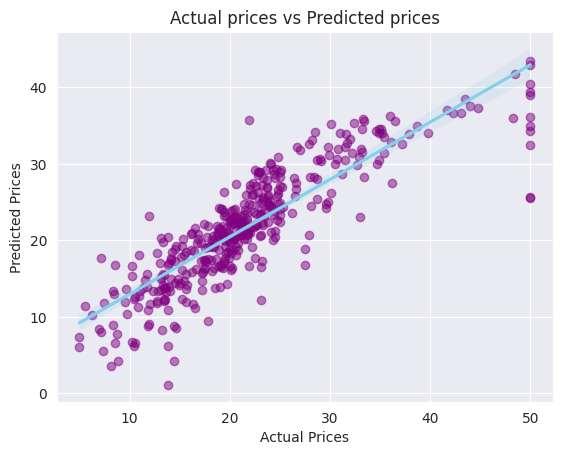

In [42]:
with sns.axes_style('darkgrid'):
    p = sns.regplot(y=predicted_values, x=y_train, scatter_kws = {'color':'purple', 'alpha':0.5}, line_kws={'color':'skyblue'})
    p.set_xlabel('Actual Prices')
    p.set_ylabel('Predicted Prices')
    p.set_title('Actual prices vs Predicted prices')
plt.show()

In [43]:
residuals = y_train - predicted_values
residuals

50    -1.33
367   10.88
34    -0.25
78     0.46
172   -0.31
       ... 
320   -1.05
15     0.01
484    1.43
125   -1.01
265   -5.77
Name: PRICE, Length: 404, dtype: float64

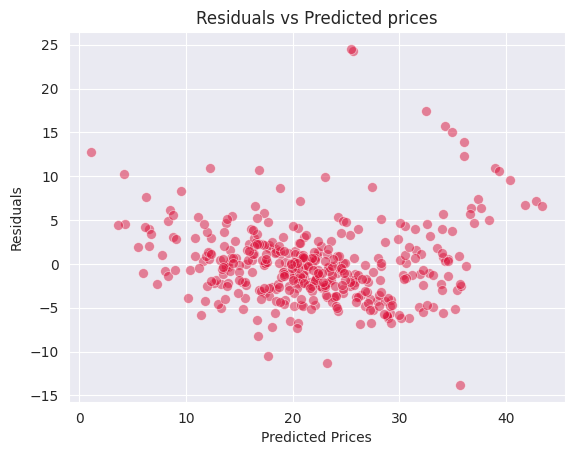

In [44]:
with sns.axes_style('darkgrid'):
    p = sns.scatterplot(y=residuals, x=predicted_values, color='crimson', alpha=0.5, s=50)
    p.set_xlabel('Predicted Prices')
    p.set_ylabel('Residuals')
    p.set_title('Residuals vs Predicted prices')
plt.show()

Why do we want to look at the residuals? We want to check that they look random. Why? The residuals represent the errors of our model. If there's a pattern in our errors, then our model has a systematic bias.

We can analyse the distribution of the residuals. In particular, we're interested in the **skew** and the **mean**.

In an ideal case, what we want is something close to a normal distribution. A normal distribution has a skewness of 0 and a mean of 0. A skew of 0 means that the distribution is symmetrical - the bell curve is not lopsided or biased to one side. Here's what a normal distribution looks like: 

<img src=https://i.imgur.com/7QBqDtO.png height=400>

**Challenge**

* Calculate the mean and the skewness of the residuals. 
* Again, use Seaborn's `.displot()` to create a histogram and superimpose the Kernel Density Estimate (KDE)
* Is the skewness different from zero? If so, by how much? 
* Is the mean different from zero?

In [45]:
print(f'The skewness is {residuals.skew():.3}')
print(f'The mean is {residuals.mean()}')
residuals.sum()


The skewness is 1.46
The mean is -3.165784466257872e-16


-1.2789769243681803e-13

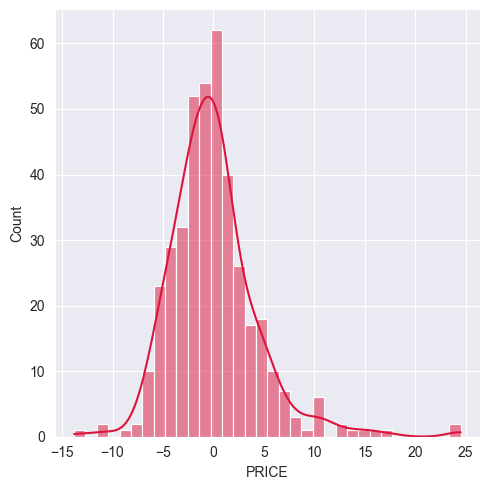

In [46]:
with sns.axes_style('darkgrid'):
    sns.displot(x=residuals, kde=True, color='crimson')
    plt.show()

### Data Transformations for a Better Fit

We have two options at this point: 

1. Change our model entirely. Perhaps a linear model is not appropriate. 
2. Transform our data to make it fit better with our linear model. 

Let's try a data transformation approach. 

**Challenge**

Investigate if the target `data['PRICE']` could be a suitable candidate for a log transformation. 

* Use Seaborn's `.displot()` to show a histogram and KDE of the price data. 
* Calculate the skew of that distribution.
* Use [NumPy's `log()` function](https://numpy.org/doc/stable/reference/generated/numpy.log.html) to create a Series that has the log prices
* Plot the log prices using Seaborn's `.displot()` and calculate the skew. 
* Which distribution has a skew that's closer to zero? 


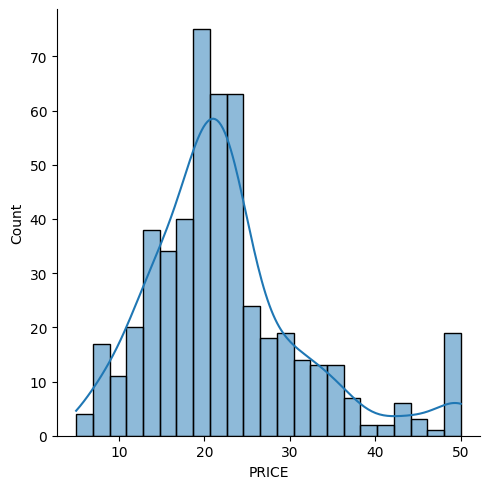

1.1080984082549072


In [47]:
sns.displot(x=data.PRICE, kde=True)
plt.show()
print(data.PRICE.skew())

In [48]:
log_prices = np.log10(data.PRICE)
print(log_prices.skew())
log_prices.mean()

-0.33032129530987697


1.31787219662266

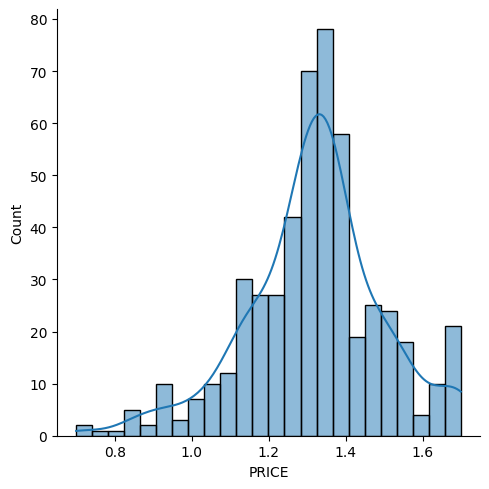

In [49]:
sns.displot(x=log_prices, kde=True)
plt.show()

#### How does the log transformation work?

Using a log transformation does not affect every price equally. Large prices are affected more than smaller prices in the dataset. Here's how the prices are "compressed" by the log transformation:

<img src=https://i.imgur.com/TH8sK1Q.png height=200>

We can see this when we plot the actual prices against the (transformed) log prices. 

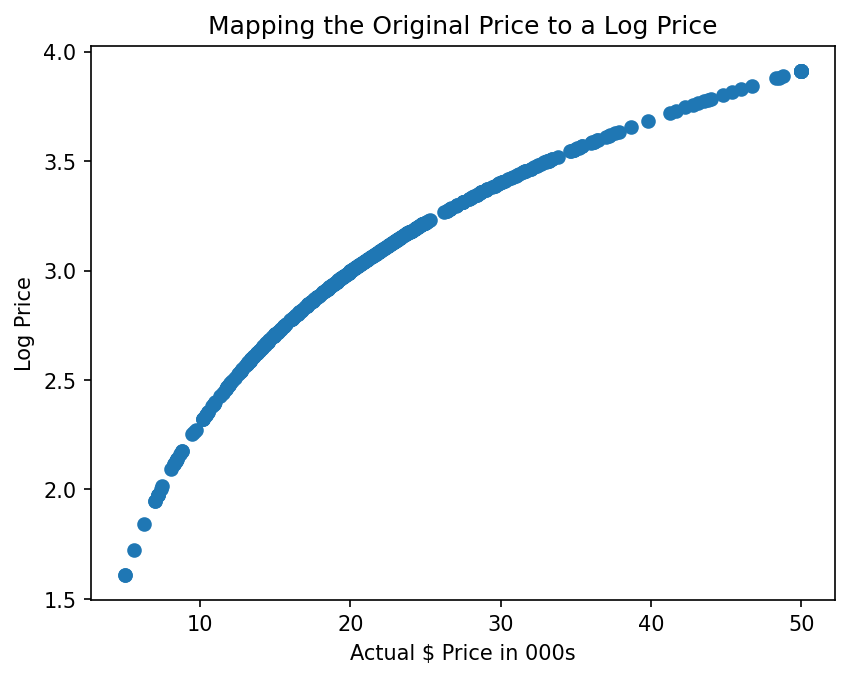

In [50]:
plt.figure(dpi=150)
plt.scatter(data.PRICE, np.log(data.PRICE))

plt.title('Mapping the Original Price to a Log Price')
plt.ylabel('Log Price')
plt.xlabel('Actual $ Price in 000s')
plt.show()

## Regression using Log Prices

Using log prices instead, our model has changed to:

$$ \log (PR \hat ICE) = \theta _0 + \theta _1 RM + \theta _2 NOX + \theta_3 DIS + \theta _4 CHAS + ... + \theta _{13} LSTAT $$

**Challenge**: 

* Use `train_test_split()` with the same random state as before to make the results comparable. 
* Run a second regression, but this time use the transformed target data. 
* What is the r-squared of the regression on the training data? 
* Have we improved the fit of our model compared to before based on this measure?


In [51]:
lg=LinearRegression()

In [52]:
log_target = np.log(target)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(features, log_target, test_size=0.2, random_state=10)

In [54]:
lg.fit(X_train, y_train)


LinearRegression()

In [55]:
lg.coef_

array([-1.06717261e-02,  1.57929102e-03,  2.02989827e-03,  8.03305301e-02,
       -7.04068057e-01,  7.34044072e-02,  7.63301755e-04, -4.76332789e-02,
        1.45651350e-02, -6.44998303e-04, -3.47947628e-02,  5.15896157e-04,
       -3.13900565e-02])

In [56]:
print(f'The r-squared is {lg.score(X=X_train, y=y_train):.2}.')

The r-squared is 0.79.


## Evaluating Coefficients with Log Prices

**Challenge**: Print out the coefficients of the new regression model. 

* Do the coefficients still have the expected sign? 
* Is being next to the river a positive based on the data?
* How does the quality of the schools affect property prices? What happens to prices as there are more students per teacher? 

Hint: Use a DataFrame to make the output look pretty. 

In [57]:
log_df = pd.DataFrame(data=lg.coef_, index=X_train.columns, columns=['Coefficient'])
log_df.loc['CRIM'].values[0]

-0.010671726123550246

## Regression with Log Prices & Residual Plots

**Challenge**: 

* Copy-paste the cell where you've created scatter plots of the actual versus the predicted home prices as well as the residuals versus the predicted values. 
* Add 2 more plots to the cell so that you can compare the regression outcomes with the log prices side by side. 
* Use `indigo` as the colour for the original regression and `navy` for the color using log prices.

In [58]:
log_predicted_values = lg.predict(X_train)
log_predicted_values.shape

(404,)

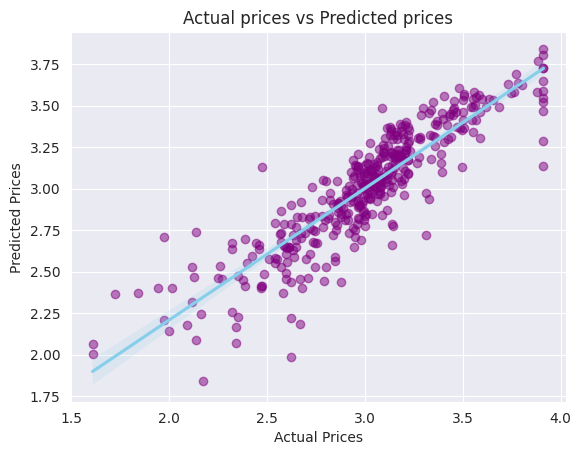

In [59]:
with sns.axes_style('darkgrid'):
    p = sns.regplot(y=log_predicted_values, x=y_train, scatter_kws = {'color':'purple', 'alpha':0.5}, line_kws={'color':'skyblue'})
    p.set_xlabel('Actual Prices')
    p.set_ylabel('Predicted Prices')
    p.set_title('Actual prices vs Predicted prices')
plt.show()

In [60]:
log_residuals = y_train - log_predicted_values
log_residuals

50    -0.06
367    0.48
34    -0.04
78     0.04
172    0.03
       ... 
320   -0.04
15    -0.03
484    0.09
125   -0.03
265   -0.20
Name: PRICE, Length: 404, dtype: float64

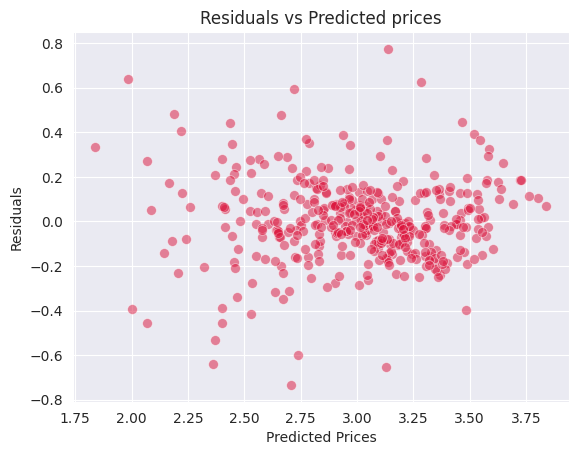

In [61]:
with sns.axes_style('darkgrid'):
    p = sns.scatterplot(y=log_residuals, x=log_predicted_values, color='crimson', alpha=0.5, s=50)
    p.set_xlabel('Predicted Prices')
    p.set_ylabel('Residuals')
    p.set_title('Residuals vs Predicted prices')
plt.show()

**Challenge**: 

Calculate the mean and the skew for the residuals using log prices. Are the mean and skew closer to 0 for the regression using log prices?

In [62]:
print(log_target.mean())
print(log_target.skew())
print(log_residuals.mean())
print(log_residuals.skew())

3.0345128744146552
-0.33032129530987864
4.589288245356464e-16
0.09299942594120904


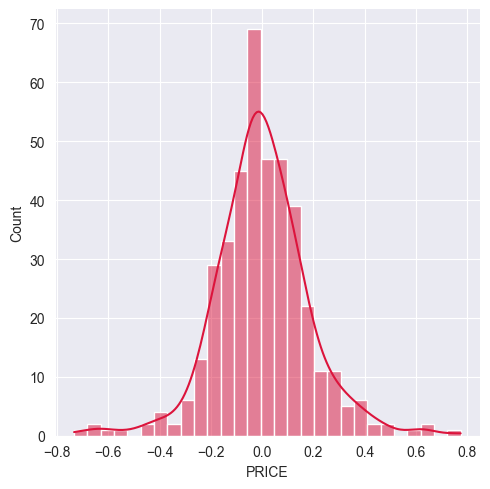

In [63]:
with sns.axes_style('darkgrid'):
    sns.displot(x=log_residuals, kde=True, color='crimson')
    plt.show()

# Compare Out of Sample Performance

The *real* test is how our model performs on data that it has not "seen" yet. This is where our `X_test` comes in. 

**Challenge**

Compare the r-squared of the two models on the test dataset. Which model does better? Is the r-squared higher or lower than for the training dataset? Why?

In [64]:
# linear_reg.fit(X_train, y_train)
print(linear_reg.score(X_train, y_train))
print(lg.score(X_train, y_train))


-2504.70937729455
0.7930234826697584


In [65]:
print(linear_reg.score(X_test, y_test))
print(lg.score(X_test, y_test))


-3109.166441005094
0.744692230626071


# Predict a Property's Value using the Regression Coefficients

Our preferred model now has an equation that looks like this:

$$ \log (PR \hat ICE) = \theta _0 + \theta _1 RM + \theta _2 NOX + \theta_3 DIS + \theta _4 CHAS + ... + \theta _{13} LSTAT $$

The average property has the mean value for all its charactistics:

In [66]:
# Starting Point: Average Values in the Dataset
features = data.drop(['PRICE'], axis=1)
average_vals = features.mean().values
property_stats = pd.DataFrame(data=average_vals.reshape(1, len(features.columns)), 
                              columns=features.columns)
property_stats

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,3.61,11.36,11.14,0.07,0.55,6.28,68.57,3.80,9.55,408.24,18.46,356.67,12.65


**Challenge**

Predict how much the average property is worth using the stats above. What is the log price estimate and what is the dollar estimate? You'll have to [reverse the log transformation with `.exp()`](https://numpy.org/doc/stable/reference/generated/numpy.exp.html?highlight=exp#numpy.exp) to find the dollar value. 

In [67]:
sum=0
for i in property_stats:
    sum+=property_stats[i][0]*(log_df.loc['CRIM'].values[0])
print(sum)


-9.721532400991642


In [68]:
log_estimate = lg.predict(property_stats)[0]
print(f'The log price estimate is ${log_estimate:.3}')

The log price estimate is $3.03


In [69]:
sum1=0
for i in property_stats:
    sum1+=property_stats[i][0]*(np.exp(log_df.loc['CRIM'].values[0]))
print(sum1)

901.2917279129442


**Challenge**

Keeping the average values for CRIM, RAD, INDUS and others, value a property with the following characteristics:

In [70]:
# Define Property Characteristics
next_to_river = True
nr_rooms = 8
students_per_classroom = 20 
distance_to_town = 5
pollution = data.NOX.quantile(q=0.75) # high
amount_of_poverty =  data.LSTAT.quantile(q=0.25) # low

In [71]:
# Solution:

